# **Machine Learning Models for Sentiment Prediction**
## **Amazon Product Review Sentiment Analysis**

### Objective
In the previous notebook, we performed exploratory data analysis and handled class imbalance.  
We now build machine learning models capable of automatically predicting customer sentiment from textual reviews.

This notebook focuses on:
- Feature extraction using TF-IDF
- Training classification algorithms
- Evaluating model performance
- Comparing models
- Saving the final trained model

The trained model will later be used to predict sentiments on unseen customer reviews.

#### **IMPORTING LIBRARIES**
We will import machine learning and evaluation libraries.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Save model
import joblib
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

#### **LOAD PROCESSED DATASET**

Loading Preprocessed Dataset

We load the balanced dataset created in Notebook-1 `01_EDA_Imbalance.ipynb`

In [45]:
df = pd.read_csv("../data/processed_train.csv")
df.head()

,clean_review,sentiment
0,powerful tablet purchased black fridaypros gre...,Positive
1,amazon echo plus awesome purchased two amazon ...,Positive
2,average average alexa option show things scree...,Neutral
3,greattttttt good product exactly wanted good p...,Positive
4,durable rd one purchased bought one nieces cas...,Positive


#### **TRAINING TEST SPLIT**
Splitting Dataset

We divide the dataset into training and validation sets.

In [46]:
X = df["clean_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### **TF-IDF FEATURE EXTRACTION**
TF-IDF Feature Engineering:

Machine learning algorithms cannot understand raw text.
We convert text into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency).

TF-IDF measures the importance of words in a review relative to all reviews.

In [47]:
print("Training data shape before vectorization:", X_train.shape)
print("Testing data shape before vectorization:", X_test.shape)

print("\nFitting TFIDF Vectorizer...")

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.8
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\nVectorization Completed!\n")

print("TFIDF Train Matrix Shape:", X_train_tfidf.shape)
print("TFIDF Test Matrix Shape:", X_test_tfidf.shape)


Training data shape before vectorization: (8997,)
Testing data shape before vectorization: (2250,)

Fitting TFIDF Vectorizer...

Vectorization Completed!

TFIDF Train Matrix Shape: (8997, 5000)
TFIDF Test Matrix Shape: (2250, 5000)


#### **CHECKING VOCABULARY SIZE**

In [48]:
print("\nTotal Vocabulary Size:", len(tfidf.vocabulary_))
print("Sample Vocabulary Terms:", list(tfidf.vocabulary_.keys())[:10])


Total Vocabulary Size: 5000
Sample Vocabulary Terms: ['overall', 'great', 'product', 'like', 'smart', 'system', 'display', 'makes', 'easier', 'talk']


#### **INSPECTING THE LEARNED VOCABULARY FROM TF-IDF VECTORIZER**

In Natural Language Processing, machine learning models cannot directly understand raw text.
Therefore, the textual review data was converted into numerical form using the TF-IDF (Term Frequency – Inverse Document Frequency) Vectorizer.

After fitting the vectorizer on the training dataset, it builds a vocabulary consisting of the most informative words and phrases (features). Each feature corresponds to a column in the TF-IDF matrix.

In this step, we retrieve and display a sample of the learned feature names to understand:

- what type of words the model considers important
- whether sentiment-related words are captured (e.g., good, bad, excellent, not good, waste money)
- whether preprocessing worked correctly
- whether meaningful bigrams (two-word combinations) were generated

The function get_feature_names_out() returns all extracted features, and we print the first 50 to inspect the vocabulary learned by the model.

In [49]:
feature_names = tfidf.get_feature_names_out()

print("\nSample Learned Words:")
print(feature_names[:50])


Sample Learned Words:
['ability' 'able' 'able access' 'able camera' 'able download' 'able get'
 'able handle' 'able respond' 'able reverse' 'able set' 'able use'
 'absolutely' 'absolutely love' 'absolutely loves' 'access'
 'access activated' 'access beyond' 'access google' 'access much'
 'accidently' 'accidently charge' 'account' 'account order'
 'account tried' 'account would' 'accounts' 'accurate' 'accurate kind'
 'activate' 'activate instead' 'activated' 'activated music' 'active'
 'active mic' 'activities' 'actual' 'actual performance' 'actually'
 'actually able' 'actually makes' 'actually solve' 'actually worked' 'ad'
 'ad happy' 'adapter' 'adapter turn' 'add' 'add junk' 'added'
 'added features']


#### **INSPECT A REAL REVIEW VECTOR**

In [50]:
print("\nFirst Review Text:\n")
print(X_train.iloc[0])

print("\nTFIDF Vector (non-zero values only):\n")
print(X_train_tfidf[0])
print("\nNon-zero TFIDF Features for First Review:")
non_zero_indices = X_train_tfidf[0].nonzero()[1]
print("Feature indices:", non_zero_indices)
print("Feature names:", [feature_names[i] for i in non_zero_indices])


First Review Text:

overall great product like currently smart system display makes easier talk device issue slow processor

TFIDF Vector (non-zero values only):

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 3049)	0.29625955021931993
  (0, 1850)	0.12348632654989666
  (0, 3332)	0.1728148596120396
  (0, 2394)	0.18193539766857025
  (0, 3976)	0.29365984251265276
  (0, 4215)	0.3018492916958614
  (0, 1189)	0.3244395444323667
  (0, 2590)	0.2704034118533712
  (0, 1259)	0.31628309993852716
  (0, 4321)	0.37567777699353316
  (0, 1115)	0.18840865526076722
  (0, 2160)	0.28117781808652326
  (0, 3949)	0.229575072925847
  (0, 1881)	0.2643019636565917

Non-zero TFIDF Features for First Review:
Feature indices: [3049 1850 3332 2394 3976 4215 1189 2590 1259 4321 1115 2160 3949 1881]
Feature names: ['overall', 'great', 'product', 'like', 'smart', 'system', 'display', 'makes', 'easier', 'talk', 'device', 'issue', 'slow', 'great

#### **BASELINE MODEL: NAIVE BAYES**
Multinomial Naive Bayes Classifier

Naive Bayes is a commonly used baseline model for text classification.
It assumes word independence and performs well on TF-IDF features.

In [51]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

#### **MODEL EVALUATION**
We evaluate using:
- Accuracy
- Precision
- Recall
- F1-Score

In [52]:
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n")
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.9728888888888889
Naive Bayes Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       750
     Neutral       0.99      0.93      0.96       750
    Positive       0.94      0.99      0.96       750

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250



#### **CONFUSION MATRIX**

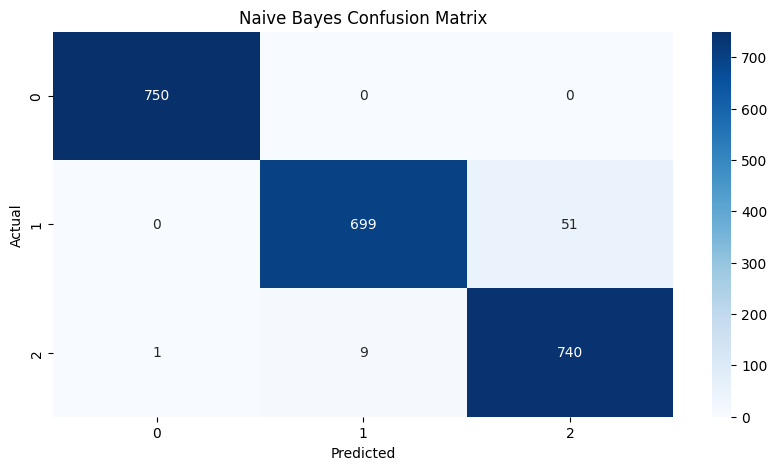

In [53]:
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### **SUPPORT VECTOR MACHINE (SVM)**

Support Vector Machines are powerful classifiers capable of handling high-dimensional text data effectively.

In [54]:
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

#### ***Evaluation***

In [55]:

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.9968888888888889
SVM Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00       750
     Neutral       0.99      1.00      1.00       750
    Positive       1.00      0.99      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



#### ***SVM CONFUSION MATRIX***

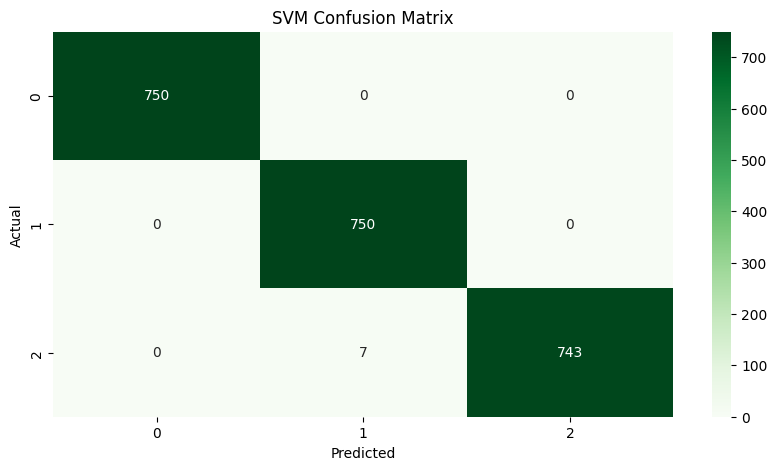

In [56]:
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### **ROC-AUC SCORE**
ROC-AUC evaluates the classifier’s ability to distinguish between classes.

In [57]:
classes = ['Negative','Neutral','Positive']
y_test_bin = label_binarize(y_test, classes=classes)

svm_decision = svm_model.decision_function(X_test_tfidf)

roc_auc_score(y_test_bin, svm_decision, average="macro")

1.0

#### **MODEL COMPARISON**
We compare the performance of Naive Bayes and SVM models.

In [58]:
nb_acc = accuracy_score(y_test, y_pred_nb)
svm_acc = accuracy_score(y_test, y_pred_svm)

print("Naive Bayes Accuracy:", nb_acc)
print("SVM Accuracy:", svm_acc)

Naive Bayes Accuracy: 0.9728888888888889
SVM Accuracy: 0.9968888888888889


#### **SAVING THE MODEL**
WE will be saving the trained model

We save:
1. TF-IDF vectorizer
2. Best performing model

These will be used to predict sentiment on unseen data.

In [59]:
# Define model directory
model_dir = Path("../models")

# Create directory if not exists
model_dir.mkdir(parents=True, exist_ok=True)

# Save TFIDF vectorizer
joblib.dump(tfidf, model_dir / "tfidf_vectorizer.pkl")

# Save trained model
joblib.dump(svm_model, model_dir / "sentiment_model.pkl")

print("Models saved successfully in 'models' folder!")

Models saved successfully in 'models' folder!


#### **TESTING ON TEST DATASET**
Validation on Test Dataset

We now test our model on the provided test dataset.

In [60]:
test_df = pd.read_csv("../data/test_data.csv")

test_df["review"] = test_df["reviews.title"].fillna("") + " " + test_df["reviews.text"].fillna("")

def clean_text(text):
    import re
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words("english"))

    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

test_df["clean_review"] = test_df["review"].apply(clean_text)

X_test_real = tfidf.transform(test_df["clean_review"])

predictions = svm_model.predict(X_test_real)

test_df["Predicted_Sentiment"] = predictions
test_df.head()

,Name of the product,Product Brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,review,clean_review,Predicted_Sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,very handy device Amazon kindle fire has a lot...,handy device amazon kindle fire lot free app u...,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Another winner from Amazon The Echo Show is a ...,another winner amazon echo show great addition...,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,simple to use and reliable so far Great value ...,simple use reliable far great value best buy b...,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,"Love it!!! I use mine for email, Facebook ,gam...",love use mine email facebook games go line als...,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Fantastic! This is a fantastic item & the pers...,fantastic fantastic item person bought loves,Positive


#### **CONCLUSION**

In this notebook, we transformed textual review data into numerical features using TF-IDF and trained machine learning classifiers for sentiment prediction.

The Support Vector Machine model outperformed the Naive Bayes classifier and was selected as the final model. The trained model and vectorizer were saved for future predictions.

This model can now automatically classify customer reviews into Positive, Negative, and Neutral categories, enabling businesses to analyze customer satisfaction at scale.